# 개요 : Kaggle의 Sales 데이터를 통해 마케팅 믹스 모델링 

마케팅 기법에서 매우 유명한 기법중 하나인 AARRR 중에 A(Acquisition)을 수행하는 분석

Acquisition(사용자 획득) : 사용자가 어떻게 서비스를 접하는가? 

주로 DAU(Daily Active User - 일일 유저 수), MAU(Monthly Active User - 월간 순 이용자), 신규유저, 방문자수, 매출 등으로 파악

## 데이터 설명
데이터는 케글에서 제공한 데이터 사용(https://www.kaggle.com/sazid28/advertising.csv/).


---

각 컬럼 설명



  * **TV** - TV 매체비
  * **radio** - 라디오 매체비
  * **newspaper** - 신문 매체비
  * **sales** - 매출액


---







## 문제 정의 
*  전제
  * 실제로는 광고 매체비 이외의 많은 요인이 매출에 영향을 미친다. (e.g. 영업인력 수, 입소문, 경기, 유행 등) 하지만 여기서는 매체비만을     주요 요인으로 간주
  * 본 분석에서는 다른 요인이 모두 동일한 상황에서 매체비만 변경했을 때 매출액의 변화가 발생한 것이라고 간주. 
  * 실제로 Acquisition 단계에서는 종속변수가 매출액보다는 방문자수, 가입자수, DAU, MAU 등의 지표가 되는 것이 더 실무적
  * 최근에는 신문등의 미디어는 잘 활용하지 않기 때문에 데이터에 맞춰서 지금 2011년에 있다고 간주.
  * 데이터의 기간이나 단위에 대한 기준이 불명확(출처에서 밝혀지지 않음) 하므로 기간은 월단위, 금액은 1억 으로 설정하여 분석한다.
  
  
* 분석의 목적 
  * 각 미디어별로 매체비를 어떻게 쓰느냐에 따라서 매출액이 어떻게 달라질지 예측.
  * 궁극적으로는 매출액을 최대화할 수 있는 미디어 믹스의 구성을 도출. 
  * 이 미디어믹스를 통해 향후 미디어 플랜을 수립할 때 사용. 

# 미디어별 광고비 EDA

필요 패키지 로드

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 컬럼 전체 확인 가능하도록 출력 범위 설정
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# 불필요한 경고 표시 생략
import warnings
warnings.filterwarnings(action = 'ignore')

## 데이터 로드

In [2]:
# 분석할 데이터 로드
data = pd.read_csv('Advertising.csv', index_col=0) #index_col=0 <-Unnamed: 0 이라는 불필요한 인덱스 컬럼 제외하고 로드

In [3]:
print(data.shape) #행열 확인
data.tail()

(200, 4)


,TV,radio,newspaper,sales
196,38.2,3.7,13.8,7.6
197,94.2,4.9,8.1,9.7
198,177.0,9.3,6.4,12.8
199,283.6,42.0,66.2,25.5
200,232.1,8.6,8.7,13.4


## 결측치 확인

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 7.8 KB


## 각 변수별 기술 통계량 확인

In [5]:
data.describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


- std(표준편차) 를 보면 TV는 매체비를 사용하는 금액의 변동폭이 크다.
- TV는 적어도 0.7억의 매체비를 매달 사용했다. (radio는 매체비를 전혀 사용하지 않는 경우도 있다)

## 변수간 Correlation 사용

- Correlation을 통해 변수간의 관계를 파악하여 분석에 사용할 수 있다.
- 컬럼수가 적기 때문에 시각화는 하지 않음

In [6]:
corr = data.corr()
corr

,TV,radio,newspaper,sales
TV,1.000000,0.054809,0.056648,0.782224
radio,0.054809,1.000000,0.354104,0.576223
newspaper,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


In [7]:
## correlation plot 
def cor(df):

    # plot size 설정 
    #f, ax = plt.subplots(figsize=(10,10)) 

    # upper matrix
    matrix = np.triu(df.corr())

    # palette 
    colormap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(df.corr(),
                    annot=True,  #실제값 표시
                    annot_kws={"size": 10}, #실제값 크기
                    fmt ='.3g', #실제값 소수점 수 지정
                    linewidths=.5, # 경계면 실선으로 바꾸기
                    center = 0, vmin=-1, vmax=1, #컬러바 범위 -1 ~ 1
                    cmap = colormap, 
                    cbar = True, # 컬러바 표시 여부
                    cbar_kws= {"shrink": 0.5} ,  # 0.5 : 컬러바 크기 반으로 줄임
                    square = True, 
                    mask = matrix) # 표시하지 않을 부분 지정
    plt.show()

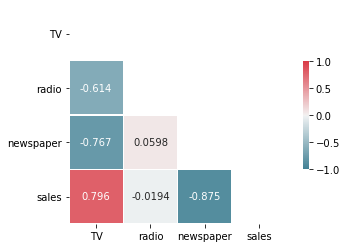

In [8]:
cor(corr)

- Salse와 TV 간의 상관관계가 가장 높으며 그 다음으로는 radio, newspaper 순으로 관계가 높다.
- 매체간에 상관관계가 높은 것은 radio 와 newspaper이다.

## 변수간의 pairplot으로 확인

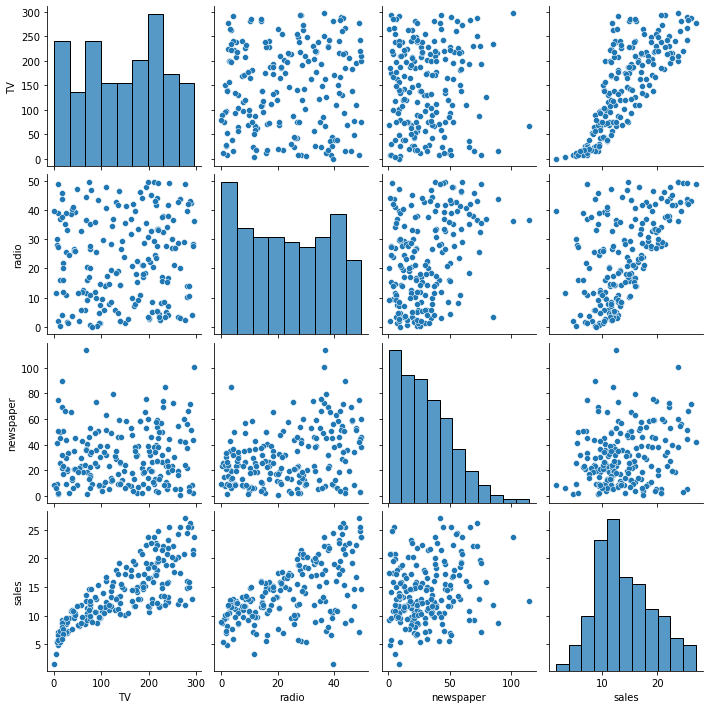

In [9]:
sns.pairplot(data[['TV','radio','newspaper','sales']])

## 변수간의 scatterplot으로 더 자세하게 확인

<AxesSubplot:xlabel='newspaper', ylabel='sales'>

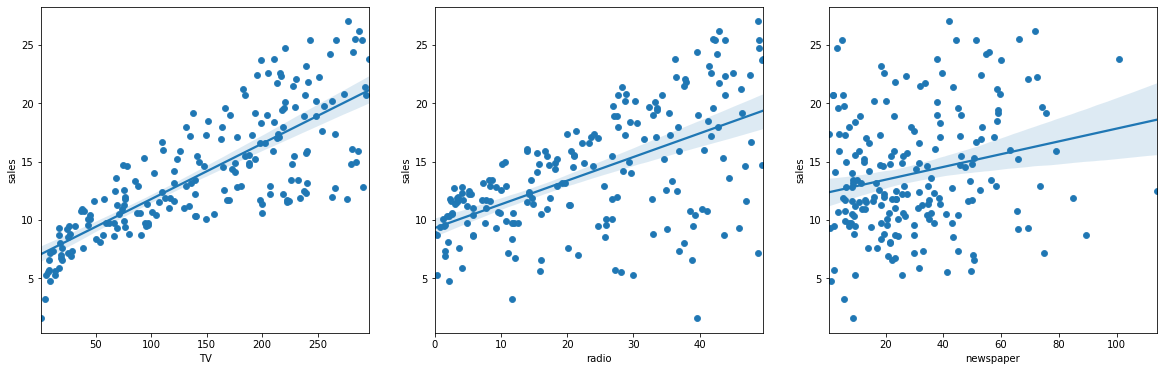

In [10]:
figure, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3) #1행 3열 형태로 subplot 그려서 3개의 plot을 하나의 도표에 그리기

#시각화할 그래프 사이즈 설정
figure.set_size_inches(20,6)

#미디어별 매체비 분포 시각화 (scatterplot) + 추세선 (regplot)
# regplot에서 옅게 표시된 부분은 추세선의 95%신뢰구간을 의미

sns.scatterplot(data=data, x='TV', y='sales', ax=ax1)
sns.regplot(data=data, x='TV', y='sales', ax=ax1)

sns.scatterplot(data=data, x='radio', y='sales',ax=ax2)
sns.regplot(data=data, x='radio', y='sales',ax=ax2)

sns.scatterplot(data=data, x='newspaper', y='sales',ax=ax3)
sns.regplot(data=data, x='newspaper', y='sales',ax=ax3)

 - sales는 각각 TV, radio와 선형관계가 있을 것으로 예측된다. 하지만 newspaper와는 선형관계를 예측하기 어렵다.

## 전처리

Label & features 지정

In [11]:
Labels = data['sales']
features = data[['TV','radio','newspaper']]

결과 확인

In [12]:
print(Labels.shape)
Labels

(200,)


1      22.1
2      10.4
3       9.3
4      18.5
5      12.9
       ... 
196     7.6
197     9.7
198    12.8
199    25.5
200    13.4
Name: sales, Length: 200, dtype: float64

In [13]:
print(features.shape)
features

(200, 3)


,TV,radio,newspaper
1,230.1,37.8,69.2
2,44.5,39.3,45.1
3,17.2,45.9,69.3
4,151.5,41.3,58.5
5,180.8,10.8,58.4
...,...,...,...
196,38.2,3.7,13.8
197,94.2,4.9,8.1
198,177.0,9.3,6.4
199,283.6,42.0,66.2


# 데이터 분석

## 선형회귀 분석(stats model)

In [14]:
#모듈 불러오기
import statsmodels.formula.api as sm

#모델생성 & fit
model1 = sm.ols(formula= 'sales~TV + radio + newspaper', data=data).fit()

#결과 확인
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Mon, 07 Jun 2021   Prob (F-statistic):           1.58e-96
Time:                        13:42:46   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.0

선형회귀 결과 해석

- R-Square 는 0.897로 매우 높은 편 (분석의 결과를 신뢰할 수 있는 정도)
- P-value가 유의한 0.05를 를 기준으로 볼때 유의한 변수는 TV, radio 이다.
  즉, sales에 유의미한 영향을 미치는 변수는 
  TV(0.0458) 와 radio(0.1885)의 매체비 이다.

- 동일 기준으로 볼때 newspaper의 매체비는 P-value 는 -0.0010으로 sales와는 상관관계가 없고 유의하지 않은 변수이다.


- 회귀식 => [ sales = 2.9389 + 0.0458*TV매체비 + 0.1885*radio 매체비 - 0.001*newspaper 매체비 ] 이다.

## 변수 포함 여부에 따른 모델 결과 확인

In [22]:
# print 결과물에 색지정 & Bold 처리
from simple_colors import *

In [21]:
model1 = sm.ols(formula = 'sales ~ TV + radio + newspaper', data=data).fit()
model2 = sm.ols(formula = 'sales ~ TV + radio', data=data).fit()
model3 = sm.ols(formula = 'sales ~ TV', data=data).fit()

print(black('[ 모든 features를 포함한 모델의 결과는 다음과 같습니다.]','bold'))
print(model1.summary())
print('\n')

print(black('[ TV와 radio feature만 포함한 모델의 결과는 다음과 같습니다.]','bold'))
print(model2.summary())
print('\n')

print(black('[ TV feature만 포함한 모델의 결과는 다음과 같습니다.]','bold'))
print(model3.summary())
print('\n')

[ 모든 features를 포함한 모델의 결과는 다음과 같습니다.]
                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Mon, 07 Jun 2021   Prob (F-statistic):           1.58e-96
Time:                        13:44:40   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     

결과 해석

*AIC : 모델의 적합도를 측정하는 지표. AIC가 낮을 수록 좋은 모델이다. 동일 데이터로 여러 feature의 조합을 할때 가장 적합한 모델이 무엇인지 판단할때 사용한다.

*BIC : AIC를 보완한 지표. 변수가 증가할수록 패널티를 부여하는 방식으로 계산. 변수증가에 AIC 보다 더 민감하다. 보통 변수개수가 '작은 것' 을 목표로 할때는 AIC보다는 BIC를 확인한다.

*AIC나 BIC이외에도 RMSE, CFI등 다른 기준을 함께 고려해서 최적 모델을 선정하는 것이 바람직 하다.


- 모든 feature을 포함한 최초의 모델에서 확인했듯이 유의하지 않은 feature인 newspaper을 제거한 mode2dml AIC, BIC 가 가장 낮다.

- 전체 feature들의 p-value를 볼때 TV 와 radio는 모두 0.05이상으로 두 매체를 사용한 광고는 sales에 영향을 주는 것이 확인된다.

- 하지만, newspaper 광고의 경우 sales 에 유의미한 영향을 주지 못하는 것으로 해석된다.

## 각 미디어별 매체비에 따른 sales 예측하기

In [30]:
# 한 기업체가 TV에 30억, radio에 10억, newspaper에 2억씩 매체비(광고)를 한다고 할때 예측되는 sales 지표

print(f"예상 sales 금액은 {model1.predict({'TV':30,'radio':10,'newspaper':2}) } 입니다." )

예상 sales 금액은 0    6.195054
dtype: float64 입니다.


In [31]:
sales = 2.9389 + 0.0458*30 + 0.1885*10 - 0.001*2

print(f" 예상 sales 금액은 {sales} 입니다.")

 예상 sales 금액은 6.1959 입니다.


sales에 가장 유의미한 feature인 TV 만을 사용한 model3의 경우

In [36]:
for i in range(3):
    print(f"예상 sales 금액은 {model3.predict({'TV':i})}  입니다." )

예상 sales 금액은 0    7.032594
dtype: float64  입니다.
예상 sales 금액은 0    7.08013
dtype: float64  입니다.
예상 sales 금액은 0    7.127667
dtype: float64  입니다.


# 문제 제기 및 해결 : 신문 데이터가 무의미 하지 않다면?

- 실무라고 가정
- 회귀분석시 신문이 유의미하지 않은 매체라고 해석 되었다.
- 하지만 마케팅 팀에서는 신문광고를 중요한 매체로 보고 있다.
- 그들은 분석을 위한 샘플수가 너무 적거나, 데이터 처리가 잘 못된것이 아닌가하는 문제를 제기하였다.

이 문제를 어떻게 해결할 것인가?

---

데이터를 탐색하는 과정에서 데이터의 분포를 제대로 살펴보지 않았음을 인지

각 데이터의 feature별 분포 확인

<AxesSubplot:xlabel='newspaper', ylabel='Density'>

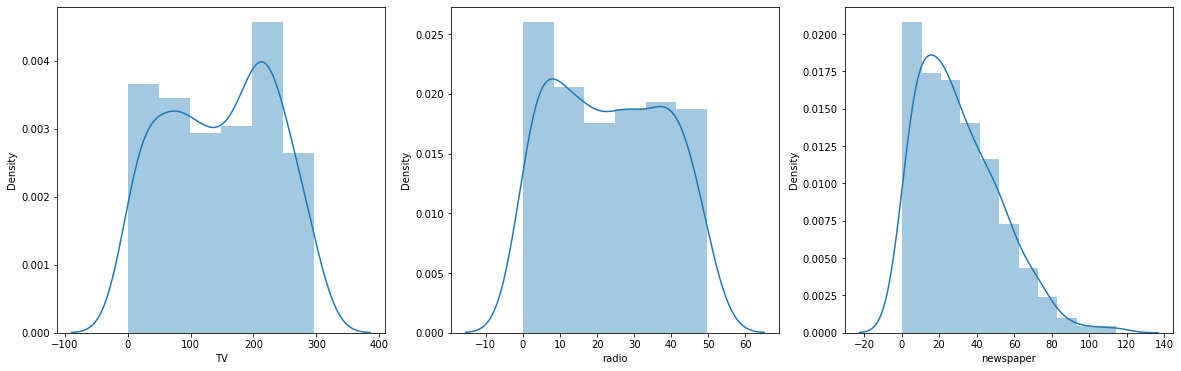

In [38]:
# 3개의 시각화를 한 화면에 배치하여 확인
# scatterplot과 동일한 form으로 시각화

figure, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3)

# 시각화할 사이즈 설정
figure.set_size_inches(20, 6)


# 미디어별 매체비 분포를 seaborn의 distplot으로 시각화
sns.distplot(data['TV'], ax=ax1)
sns.distplot(data['radio'], ax=ax2)
sns.distplot(data['newspaper'], ax=ax3)

- TV와 radio의 경우는 매체비(광고비) 가격대별로 고르게 분포가 되어있다.
- 하지만 newspaper의 경우 저렴한 광고에 대부분의 건수가 몰려있는 것을 확인할 수 있다.

이를 해결하기 위해 모든 데이터들을 정규화 하여 0~1사이의 값으로 변경한 뒤에 동일 분석을 재시행

In [39]:
import numpy as np

로그값을 취할때 로그값이 0이 되면 음의 무한대값이 된다.

따라서 상수를 더하여 로그값이 0이되지 않도록 하는 것이 로그를 통한 정규화의 포인트이다.

In [41]:
data['log_newspaper']=np.log(data['newspaper']+1) #로그값이 0이되지 않게 하기위해 +1 처리

#결과 확인
print(data.shape)
data[['log_newspaper', 'newspaper']]

(200, 5)


,log_newspaper,newspaper
1,4.251348,69.2
2,3.830813,45.1
3,4.252772,69.3
4,4.085976,58.5
5,4.084294,58.4
...,...,...
196,2.694627,13.8
197,2.208274,8.1
198,2.001480,6.4
199,4.207673,66.2


로그값 취한 newspaper의 분포 확인

<AxesSubplot:xlabel='log_newspaper', ylabel='Density'>

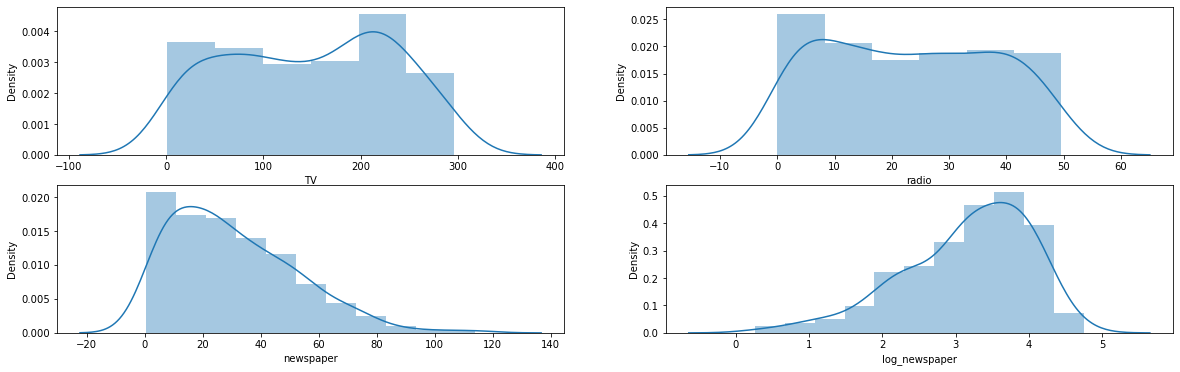

In [45]:
# 4개의 시각화를 한 화면에 배치하여 확인

# scatterplot과 동일한 form으로 시각화

figure, ( (ax1, ax2), (ax3, ax4) ) = plt.subplots(nrows=2, ncols=2)

# 시각화할 사이즈 설정
figure.set_size_inches(20, 6)


# 미디어별 매체비 분포를 seaborn의 distplot으로 시각화
sns.distplot(data['TV'], ax=ax1)
sns.distplot(data['radio'], ax=ax2)
sns.distplot(data['newspaper'], ax=ax3)
sns.distplot(data['log_newspaper'], ax=ax4)

In [46]:
model1 = sm.ols(formula = 'sales ~ TV + radio + newspaper', data=data).fit()
model4 = sm.ols(formula = 'sales ~ TV + radio + newspaper+log_newspaper', data=data).fit()

print(black('[ 모든 features를 포함한 모델의 결과는 다음과 같습니다.]','bold'))
print(model1.summary())
print('\n')

print(black('[ TV와 radio, newspaper, log_newspaper feature를 포함한 모델의 결과는 다음과 같습니다.]','bold'))
print(model4.summary())

[ 모든 features를 포함한 모델의 결과는 다음과 같습니다.]
                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Mon, 07 Jun 2021   Prob (F-statistic):           1.58e-96
Time:                        14:20:38   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     

- model1과 비교해 본다면 newspaper의 상관관계 (coef) 는 다소 증가하였으나 여전히 p-value 적합 기준인 0.05에는 미치지 못한다.

- 결론적으로 신문 매체광고는 sales 증가에 적합하지 않은 광고 매체임을 재확인 할 수 있다.

# 모델 적합도 검증

## 평가지표 함수 생성

In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

my_predictions = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]

def plot_predictions(name_, pred, actual):
    df = pd.DataFrame({'prediction': pred, 'actual': Labels})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(12, 9))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

def mse_eval(name_, pred, actual):
    global predictions
    global colors

    plot_predictions(name_, pred, actual)

    mse = mean_squared_error(pred, actual)
    my_predictions[name_] = mse

    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(y_value, columns=['model', 'mse'])
    print(df)
    min_ = df['mse'].min() - 10
    max_ = df['mse'].max() + 10
    
    length = len(df)
    
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['mse'])
    
    for i, v in enumerate(df['mse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('MSE Error', fontsize=18)
    plt.xlim(min_, max_)
    
    plt.show()

## MSE로 모델 정확도 확인

MSE (Mean Squared Error) 

즉 잔차값(예측과 실제값 간의 차이 = 모델이 얼마나 틀렸는가) 에 절대값을 취하고 평균을 낸 값
가장 직관적으로 모델의 성능을 파악할 수 있는 지표

잔차값이 0에 가까울 수록 예측이 잘 된 모델이라고 할 수 있다.

In [57]:
# sklearn의 회귀분석 코드로 MSE 확인
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

In [51]:
model = LinearRegression().fit(features, Labels))
pred = model.predict(features)

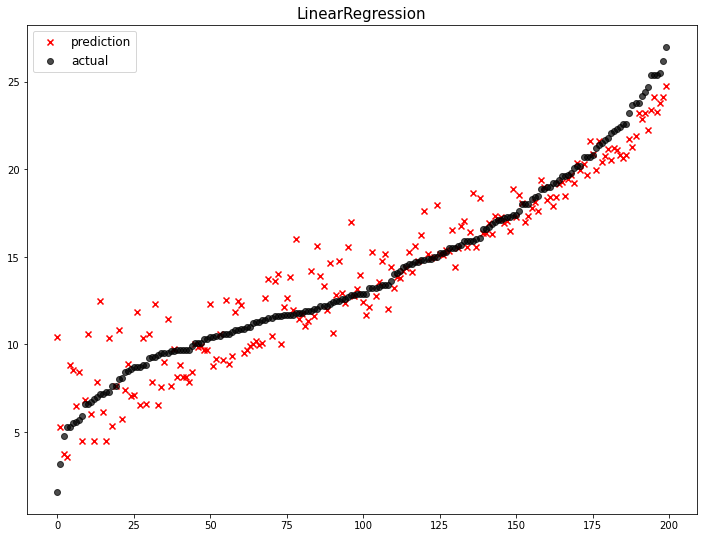

              model       mse
0  LinearRegression  2.784126


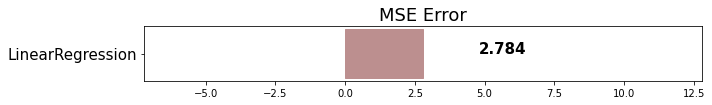

In [56]:
mse_eval('LinearRegression', pred, Labels)

- 검은점은 실제 sales의 값
- 빨간색 x는 회귀 모델을 통해 예측한 sales의 값이다.

즉 실제값과 예측값이 다른 정도(잔차값)의 평균이 2.274정도로 모델 성능이 상당히 높은 것이라 할 수 있다.

# 결론

- 2011년 기준으로 볼때 마케팅 팀에서는 newspaper이 유효한 광고 수단이라 생각하지만 실제로는 그렇지 않다.

- 그러므로 신문광고에 투자하는 비용을 TV 와 radio 광고에 활용하는 것이 더 바람직하다.

- 그런데 회귀지표로 볼때 TV광고는 비용대비 효율이 라디오에 비해 떨어집니다. 
  (TV , radio가 sales에 영향을 미치는 정도를 확인한 model2기준 둘의 상관계수는 각각 TV = 0.0458 , radio=0.1880 이다.)
  (동일 금액을 투자한다고 하였을때 TV는 sales를 1억당 0.0458의 매출 성과를, radio는 1억당 0.1880 매출 성과를 올리는데 기여한다.)
  

- 그러므로 우리 제품은 라디오를 통해 광고를 할 수록 가장 잘 팔리는 상품이라 할 수 있다.
  
